In [1]:
import shap
import torch
import resnn

d:\001Drexel\99_hackathon\4_CODEFEST2024\Philly-Codefest\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Deploy

In [47]:
import torch
from my_model.code import inference 
import librosa
import json

# Simulate SageMaker's model_fn
model_dir = './my_model'  # Replace with the path to your model directory
model = inference.model_fn(model_dir)

# Load a sample audio file using librosa
audio_path = '../data/train/1_10142.wav'  # Replace with the path to your audio file
signal, sr = librosa.load(audio_path, sr=None, mono=True)

# Create a JSON object with the signal and sample rate
input_json = json.dumps({'signal': signal.tolist(), 'sr': sr})

# Simulate SageMaker's input_fn with JSON content
input_data = inference.input_fn(input_json, 'application/json')


print(type(input_data))
print(input_data.shape)
# Simulate SageMaker's predict_fn
prediction = inference.predict_fn(input_data, model)

# Simulate SageMaker's output_fn
output = inference.output_fn(prediction, 'application/json')

# Print the output
print(output)


<class 'numpy.ndarray'>
(1, 3, 128, 250)
torch.Size([1, 3, 128, 250]) cuda
{'class': 1, 'confidence': 0.9617887735366821}


## preprocessing

In [3]:
import librosa
import argparse
import pandas as pd
import numpy as np
import pickle as pkl 
import torch
import torchaudio
import torchvision
from PIL import Image
import os

sample_rate = 44100
segment_length = 5
n_fft = 4410
n_mels = 128
n_mfcc = 20
denoise = False
# data_dir = os.path.join(dir_fsc22,'audio')

def extract_signal_spectrogram(signal):
	num_channels = 3
	window_sizes = [25, 50, 100]
	hop_sizes = [10, 25, 50]
	centre_sec = 2.5

	specs = []
	for i in range(num_channels):
		window_length = int(round(window_sizes[i]*sample_rate/1000))
		hop_length = int(round(hop_sizes[i]*sample_rate/1000))

		signal = torch.Tensor(signal)
		spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4410, win_length=window_length, hop_length=hop_length, n_mels=128)(signal)
		eps = 1e-6
		spec = spec.numpy()
		spec = np.log(spec+ eps)
		spec = np.asarray(torchvision.transforms.Resize((128, 250))(Image.fromarray(spec)))
		specs.append(spec)

	return np.array(specs)



In [49]:
data_dir = '../data/train/1_10142.wav'
signal,sr = librosa.load(os.path.join(data_dir), sr=sample_rate)
spectrogram = extract_signal_spectrogram(signal)

## visualization

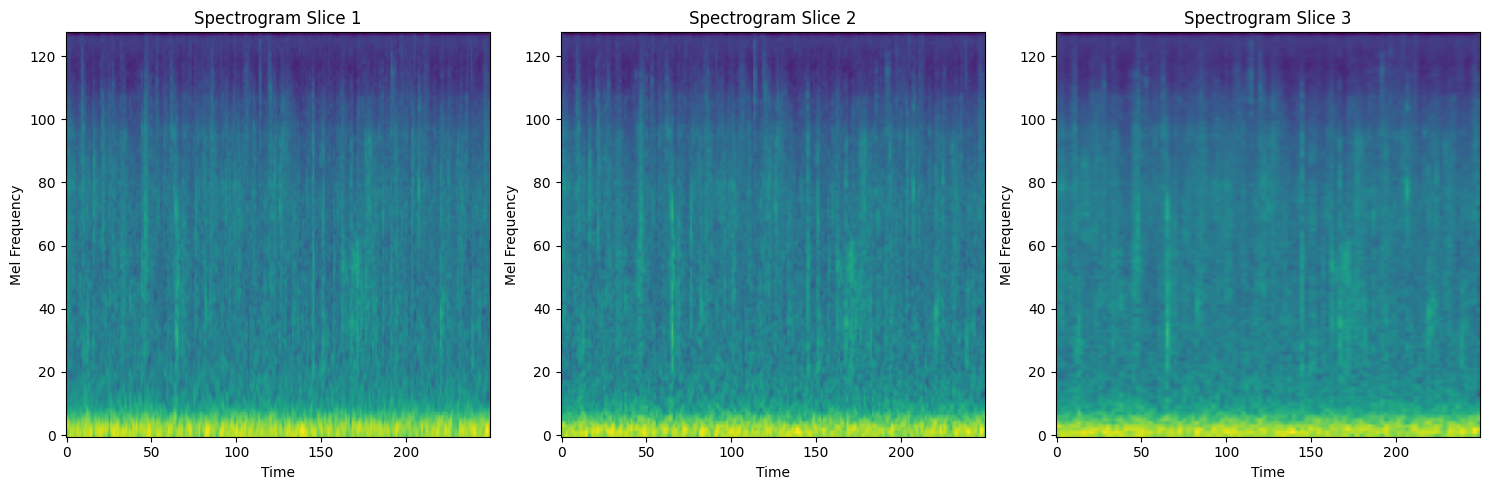

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each slice (along the first dimension)
for i in range(spectrogram.shape[0]):
    # Display the spectrogram slice
    axes[i].imshow(spectrogram[i, :, :], aspect='auto', origin='lower')
    axes[i].set_title(f'Spectrogram Slice {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

## Explain on graph

In [6]:
import matplotlib.pyplot as plt
import shap

In [7]:
spectrogram

array([[[  1.317866  ,   3.1748626 ,   4.2174163 , ...,   4.8746886 ,
           3.910346  ,   0.61194235],
        [  1.7439029 ,   2.0060441 ,   4.0713544 , ...,   5.560019  ,
           4.557986  ,   1.4351081 ],
        [  3.0606384 ,   3.2036572 ,   3.7237597 , ...,   5.565762  ,
           4.6672587 ,   1.862093  ],
        ...,
        [ -7.982757  ,  -7.8367767 ,  -7.5307345 , ...,  -7.848393  ,
          -8.365711  ,  -8.020167  ],
        [ -8.281451  ,  -8.143888  ,  -8.342779  , ...,  -8.249382  ,
          -8.485529  ,  -8.362688  ],
        [ -9.297261  , -10.093364  , -10.540486  , ..., -10.329992  ,
         -10.3886    ,  -8.925135  ]],

       [[  3.25881   ,   3.6729052 ,   4.931675  , ...,   5.0780582 ,
           3.9689963 ,   1.3627567 ],
        [  4.385795  ,   3.1230507 ,   3.951466  , ...,   6.4045258 ,
           4.982699  ,   1.9209908 ],
        [  3.6660898 ,   3.5680752 ,   3.5533268 , ...,   6.448266  ,
           5.360293  ,   3.0496607 ],
        ...,


In [8]:
# model.eval()
# e = shap.DeepExplainer(model, spectrogram_tensor)
# print(e)

In [9]:
from sklearn.model_selection import train_test_split
validation_size = 0.05
dir_fsc22 = '../data/fsc22'
df_fsc22 = pd.read_csv(os.path.join(dir_fsc22,'metadata.csv'))
df_fsc22.rename(columns={'Dataset File Name': 'filename'}, inplace=True)
df_fsc22.rename(columns={'Class ID': 'target'}, inplace=True)
df_fsc22['target'] = df_fsc22['target']-1
# Assuming df_fsc22 is your DataFrame and 'target' is the column for stratification
df_train, df_test = train_test_split(df_fsc22, test_size=validation_size, stratify=df_fsc22['target'], random_state=42)

In [10]:
# Create the dataset and dataloader
features = resnn.extract_features(df_train)
train_dataset = resnn.AudioDataset(features)
train_loader = resnn.DataLoader(train_dataset, batch_size=100, shuffle=True)

features = resnn.extract_features(df_test)
test_dataset = resnn.AudioDataset(features)
test_loader = resnn.DataLoader(test_dataset, batch_size=3, shuffle=True)

Finished audio 8_10873.wav
Finished audio 6_10613.wav
Finished audio 8_10844.wav
Finished audio 17_11737.wav
Finished audio 10_11039.wav
Finished audio 1_10115.wav
Finished audio 25_12534.wav
Finished audio 3_10337.wav
Finished audio 3_10339.wav
Finished audio 12_11273.wav
Finished audio 21_12159.wav
Finished audio 25_12503.wav
Finished audio 14_11422.wav
Finished audio 22_12220.wav
Finished audio 10_11066.wav
Finished audio 12_11272.wav
Finished audio 15_11566.wav
Finished audio 7_10712.wav
Finished audio 9_10947.wav
Finished audio 5_10547.wav
Finished audio 17_11751.wav
Finished audio 24_12443.wav
Finished audio 4_10406.wav
Finished audio 27_12722.wav
Finished audio 19_11962.wav
Finished audio 3_10332.wav
Finished audio 21_12120.wav
Finished audio 11_11169.wav
Finished audio 13_11372.wav
Finished audio 18_11830.wav
Finished audio 16_11623.wav
Finished audio 18_11813.wav
Finished audio 8_10810.wav
Finished audio 18_11833.wav
Finished audio 17_11720.wav
Finished audio 3_10345.wav
Finis

In [11]:
device = resnn.get_cuda_device()
background = next(iter(train_loader))[0].to(device)
test_images = next(iter(test_loader))[0].to(device)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
model.to(device)
model.eval()
e = shap.DeepExplainer(model, background)

In [14]:
shap_values = e.shap_values(test_images)

RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

In [ ]:
train_dataset.features

In [ ]:
e = shap.DeepExplainer(model, train_dataset)
shap_values = e.shap_values(test_images)

TypeError: conv2d() received an invalid combination of arguments - got (AudioDataset, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!AudioDataset!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!AudioDataset!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:
shap_values = e.shap_values(spectrogram_tensor.to('cpu'))

NameError: name 'e' is not defined

In [ ]:
background.shape

torch.Size([100, 3, 128, 250])

In [ ]:
test_images.shape

torch.Size([3, 3, 128, 250])

In [40]:
spectrogram_np.shape

(3, 128, 250)

In [52]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your pre-trained model and 'spectrogram' is your input tensor

# Define the target layers you want to visualize
target_layers = [model.layer4[-1]]  # Example: using the last layer of ResNet50

# Initialize GradCAM with the model and target layers
cam = GradCAM(model=model, target_layers=target_layers)

# If your spectrogram is not already in RGB format, convert it to RGB
spectrogram_rgb = np.transpose(spectrogram, (1, 2, 0))
spectrogram_rgb = spectrogram_rgb - spectrogram_rgb.min()
spectrogram_rgb = spectrogram_rgb / spectrogram_rgb.max()

# Create a tensor from the spectrogram to pass to GradCAM
input_tensor = tensor.from_numpy(spectrogram).unsqueeze(0)  # Add batch dimension

# Define the target category for which you want to visualize the CAM
# If you want to visualize the CAM for the predicted class, you can leave targets as None
targets = None  # or [ClassifierOutputTarget(predicted_class)] if you have a specific class

# Generate the CAM mask
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

# Use the mask to create a heatmap on the image
visualization = show_cam_on_image(spectrogram_rgb, grayscale_cam, use_rgb=True)

# Display the image
plt.imshow(visualization)
plt.show()

# You can also get the model outputs without having to re-inference
model_outputs = cam.model_outputs


NameError: name 'tensor' is not defined

In [53]:
import torchvision.models as models

# Assuming model is a pre-loaded or pre-trained model
# Check the number of layers
if isinstance(model, models.resnet.ResNet):
    if len(list(model.children())) == 34:
        print("The model is ResNet-34")
    elif len(list(model.children())) == 50:
        print("The model is ResNet-50")
    else:
        print("The model is not ResNet-34 or ResNet-50")
else:
    print("The model is not a ResNet model")


The model is not ResNet-34 or ResNet-50


In [54]:
len(list(model.children()))

10

In [55]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
import shap
import numpy as np
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)
model_path = './my_model/trained_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  